In [156]:
import twitter
import re
import json
import pandas as pd

def left(s, amount = 1, substring = ""):
    if (substring == ""):
        return s[:amount]
    else:
        if (len(substring) > amount):
            substring = substring[:amount]
        return substring + s[:-amount]

def right(s, amount = 1, substring = ""):
    if (substring == ""):
        return s[-amount:]
    else:
        if (len(substring) > amount):
            substring = substring[:amount]
        return s[:-amount] + substring
def remove_duplicates(values):
    output = []
    seen = set()
    for value in values:
        # If value has not been encountered yet,
        # ... add it to both list and set.
        if value not in seen:
            output.append(value)
            seen.add(value)
    return output


CONSUMER_KEY ="wL8xOLpaozc5igQgSpc5SmWRu"
CONSUMER_SECRET ="3pUVWDURtNojYGITOtAVZkLm1t4ZHtvxdZSBWiTYgWxa1E5KoH"
OAUTH_TOKEN = "921778257032351744-9BtaFSbyYQ7SAVkvAdQxo3nz2XIUmso"
OAUTH_TOKEN_SECRET = "0eXbrJWeZiTJCOcvK7vQ6HeedszbIo17MMpgGQBAvskHm"

auth = twitter.oauth.OAuth (OAUTH_TOKEN, OAUTH_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET)
twitter_api= twitter.Twitter(auth=auth)
search_results = twitter_api.search.tweets(q='#soccer' or '#pl',count='1000000',lang='en')
statuses = search_results['statuses']

for _ in range(100):
    print ("Length of statuses", len(statuses))
    try:
        next_results = search_results['search_metadata']['next_results']
    except KeyError:   
        break
   # Create a dictionary from next_results
    kwargs=dict( [kv.split('=') for kv in next_results[1:].split("&") ])

    search_results = twitter_api.search.tweets(**kwargs)
    statuses += search_results['statuses']

#print (statuses)
df = pd.DataFrame(columns=['created_at','urls','hashtags','text'])
i=0
for status in statuses:
    hashtags=[]
    urls=[]
    for hashtag in status['entities']['hashtags']:
        h = hashtag['text'].lower()
        hashtags.append(h) 
    for url in status['entities']['urls']:
        urls.append(url['url']) 
    texts =  status['text'].lower()
    texts =  re.sub(r'https?:\/\/.*[\r\n]*', '', texts, flags=re.MULTILINE)
    texts = re.sub(r'[?|$|.|&|[|!|%|\-|*|;|#|"|\n|,|@|(|)]',r'',texts)
    texts = re.sub(r'[0|1|2|3|4|5|6|7|8|9|:]',r'',texts)       

    created_ats = status['created_at']
    created_ats = pd.to_datetime(created_ats)
    df.loc[i]=[created_ats,urls,hashtags,texts]
    i+=1

#print (df.head())

Length of statuses 100
Length of statuses 200
Length of statuses 200


In [185]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk import bigrams 
import string

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, Select,LabelSet


count_terms = Counter()  #counter for all the words
terms_all = [] #list of all the tokens in tweets
terms_bigram = []
stop = stopwords.words('english') +['rt'] + list(string.punctuation) #removing retweet 'rt'

texts = df['text']    
#print (df.head())
for counter, t in enumerate(texts):
    if t.startswith("rt @"):
        pos= t.find(": ")
        texts[counter] = right(t, len(t) - (pos+2))

#texts= remove_duplicates(texts)

for t in texts:
    tokens = [i for i in word_tokenize(t.lower()) if i not in stop]
    count_terms.update(tokens)
    terms_all.extend(tokens)
    terms_bigram.extend(bigrams(tokens))

common_terms = dict(count_terms.most_common(10))
terms_all = list(set(terms_all))

#similarly for hashtags

count_hashtags = Counter()
hashtags_all = []
hashtagsDf = df['hashtags']

for hashtag in hashtagsDf:
    for h in hashtag:
        tokens = [i for i in word_tokenize(h) if i not in stop]
        count_hashtags.update(tokens)
        hashtags_all.extend(tokens)

common_hashtags = dict(count_hashtags.most_common(10))
hashtags_all = list(set(hashtags_all))


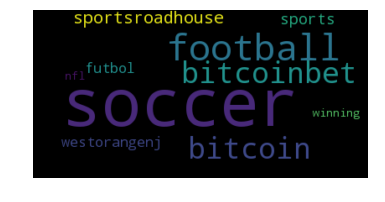

In [198]:
'''
Have to download wordcloud first
Download the .whl file compatible with your Python version and your windows distribution (32bit or 64bit) 
from http://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud
cd to the file path
Run this command python -m pip install <filename>'''

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud().generate_from_frequencies(common_hashtags)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [194]:
commonWordsPlot=figure(x_range =list(set(common_terms)),plot_height=300, plot_width=900, title='Most Common words #soccer')
commonWordsData = ColumnDataSource(data=dict(x=list(common_terms.keys()),y=list(common_terms.values()),
                                  label = list(common_terms.values())))
labels0 = LabelSet(x='x', y='y', text='label', level='glyph',
                  x_offset=5, y_offset=5, source=commonWordsData, render_mode='canvas')
commonWordsPlot.add_layout(labels0)
commonWordsPlot.vbar(x='x',top='y',source=commonWordsData,width=1)
show(commonWordsPlot)


hPlot=figure(x_range =list(set(common_hashtags)),plot_height=300, plot_width=900, title='Most popular associated Hashtags')
commonHashtagsData = ColumnDataSource(data=dict(x=list(common_hashtags.keys()),y=list(common_hashtags.values()),
                                               label = list(common_hashtags.values())))
hPlot.vbar(x='x',top='y',source=commonHashtagsData,width=1)
labels1 = LabelSet(x='x', y='y', text='label', level='glyph',
                  x_offset=5, y_offset=5, source=commonHashtagsData, render_mode='canvas')
commonWordsPlot.add_layout(labels1)
show(hPlot)
#print(terms_all)

In [158]:
import nltk
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

stemmer = SnowballStemmer("english")

#take comments from dataframe
textDF = df['text']

#token given text and find their stems
def tokenize(text):
    textTokens=[]
    #for userComments in commentsDf:
    textTokens = (nltk.word_tokenize(text))
    #filter out punctuations and numeric tokens
    return textTokens

#create stem dictionary for all the commments
totalVocabTokens = []
for i in textDF:
    totalVocabTokens.extend(nltk.word_tokenize(i))

print (totalVocabTokens)
#making Term Frequency-Inverse document Frequency matrix model
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                 min_df=0, stop_words='english',
                                 use_idf=True,tokenizer=tokenize, ngram_range=(1,3))  #creating features by taking 3 words at a time

tfidf_matrix = tfidf_vectorizer.fit_transform(textDF)
print (tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()
#terms are list of features in the matrix
#print (terms)



['soccer', 'bbc', 'sport', 'premier', 'league', 'results', 'man', 'city', 'beat', 'burnley', 'man', 'utd', 'lose', 'at', 'huddersfield', 'chelsea', 'rally', 'soccer', 'nfl', 'futbol', 'armored', 'football', 'jersey', 'rt', 'betfastbtc', 'bitcoin', 'bitcoinbet', 'soccer', '⚽️', 'monaco', 'beat', 'caen', 'to', 'keep', 'up', 'pressure', 'on', 'psg', 'nantes', 'win', 'to', 'go', 'third', '→', 'via…', 'rt', 'sportsroadhouse', 'soccer', 'soccer', 'aguero', 'equals', 'man', 'city', 'scoring', 'record', 'heading', 'to', 'el', 'camino', 'college', 'for', 'game', 'against', 'la', 'galaxy', 'sd', 'gobeach', 'soccer', 'bitcoin', 'bitcoinbet', 'soccer', '⚽️', 'chelsea', "'s", 'vital', 'comeback', '→', 'via', 'rt', 'duchesshazard', 'saturdayshare', 'brumbleboutique', 'has', 'scarfs', 'to', 'keep', 'you', 'warm', 'while', 'watching', 'soccer', 'and', 'football', 'games', 'rt', 'sportsroadhouse', 'soccer', 'soccer', 'ileague', 'east', 'bengal', 'set', 'to', 'sign', 'former', 'mohun', 'bagan', 'defende

In [159]:
from sklearn.cluster import KMeans,DBSCAN

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

db = DBSCAN(eps=0.4,min_samples=6)
db.fit(tfidf_matrix)
clustersDB = db.labels_.tolist()
clusters = km.labels_.tolist()
#clusters is a list corresponding to 1338 rows in df
#print (clusters)
#add clusters to dataframe
df['clusters']  =clustersDB
#print (df.head())
#show the distribution of clusters
#print (df['clusters'].value_counts())

order_centroids = km.cluster_centers_.argsort()[:,::-1]
print (order_centroids)

for centres in order_centroids:
    topFeatures=[]
    for words in centres[:6]:
        topFeatures.append(terms[words])
    print (topFeatures)

[[2049 2581  235 ..., 1738 1737 1319]
 [1920 1730 2384 ...,  131  130  426]
 [ 929 1122 1120 ..., 1753 1752    0]
 [2094 2476  302 ..., 1740 1739    0]
 [1878 1330 1668 ..., 1753 1752    0]]
['soccer ⚽️', '⚽️', 'bitcoinbet soccer', 'bitcoin', 'bitcoinbet soccer ⚽️', 'bitcoin bitcoinbet']
['soccer', 'rt', 'vs', 'amp', "'s", 'game']
['helps la', 'liga leaders barcelona', 'liga', 'leaders', 'ndminute goal helps', 'ndminute goal']
['south_suburban', 'win', 'caen pressure', 'beat caen', 'beat caen pressure', 'nantes']
['serie napoli', 'napoli remain', 'remain', 'remain points', 'remain points inter', 'share']


In [160]:
from sklearn.manifold import MDS
#dimensionality reduction for the TF-IDF matrix (or df equally)
MDS()

# convert two components as we're plotting points in a two-dimensional plane

# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, random_state=1)

#toarray() converts sparse array to dense numpy array
pos = mds.fit_transform(tfidf_matrix.toarray())  # shape (n_components, n_samples)

#store the dimensions in xs, ys
xs, ys = pos[:, 0], pos[:, 1]


In [161]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, Select,LabelSet

def get_colors(clusters):
    colors=[]
    for i in clusters:
        if i==-1:
            colors.append('violet')
        if i==0:
            colors.append('red')
        if i==1:
            colors.append('blue')
        if i==2:
            colors.append('green')
        if i==3:
            colors.append('brown')
        if i==4:
            colors.append('yellow')
        if i==5:
            colors.append('pink')
        if i==6:
            colors.append('orange')
    return colors

colors = get_colors(clusters)



output_notebook()
'''
a=figure(x_range =list(set(list(df['user']))),plot_height=500, plot_width=900, title='clustering groups based on edits')
data = ColumnDataSource(data=dict(x=df['user'],y=df['timestamp'],colors = colors,label=df['tags']))
a.square('x','y',fill_color='colors',line_color='colors',source=data,size=10)
#users are label
labels = LabelSet(x='x', y='y', text='label', level='glyph',
                  x_offset=5, y_offset=5, source=data, render_mode='canvas')
#a.add_layout(labels)
show(a)
'''
#print(data.column_names)
b=figure( plot_height=500, plot_width=900, title='clustering groups based on edits')
data1 = ColumnDataSource(data=dict(x=xs,y=ys,colors = colors,label=df['text']))
b.square('x','y',fill_color='colors',line_color='colors',source=data1,size=10)
#user are labels
labels = LabelSet(x='x', y='y', text='label', level='glyph',
                  x_offset=5, y_offset=5, source=data1,render_mode='canvas')
b.add_layout(labels)
show(b)

Loading BokehJS ...